# 18.335 Problem Set 2

This notebook accompanies the second problem set posted on the [18.335 web page](https://github.com/mitmath/18335), and is here to get you started with your own Julia computations.

Download this notebook (a `pset2.ipynb` file) by **right-clicking the download link** at the upper-right to *Save As* a file, and then drag this file into your Jupyter dashboard to upload it (e.g. on [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mitmath/binder-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fmitmath%252F18335%26urlpath%3Dtree%252F18335%252F%26branch%3Dmaster) or in a local installation).

Modify it as needed, then choose **Print Preview** from the "File" menu and *print to a PDF* file to submit electronically.

# Problem 2: Banded factorization of a finite-difference matrix

Develop your algorithm for a banded factorization of $A=I+\sigma D$ in the following sections. The flops required to compute the factorization should scale linearly with the dimension of $A$ (e.g., if $A$ is $n\times n$, then ${\rm \#flops}=\mathcal{O}(n))$. Here are the problem parameters and a banded representation of our finite-difference discretization to get you started.

In [60]:
using LinearAlgebra
using BandedMatrices

## PDE and discretization parameters
α = 1                           # velocity
n = 199                         # discretization size
Δx = 1 / (n+1)                  # grid spacing
Δt = 0.005                      # time step
σ = α*Δt/Δx                     # shift

## scaled 2nd order central difference matrix plus identity
D = BandedMatrix(-2 => ones(n-2)/12, -1 => -2*ones(n-1)/3, 0=> zeros(n), 1 => 2*ones(n-1)/3, 2 => -ones(n-2)/12)
A = BandedMatrix(Eye(n), (2,2)) + σ * D

199×199 BandedMatrix{Float64} with bandwidths (2, 2):
  1.0         0.666667   -0.0833333  …    ⋅           ⋅           ⋅ 
 -0.666667    1.0         0.666667        ⋅           ⋅           ⋅ 
  0.0833333  -0.666667    1.0             ⋅           ⋅           ⋅ 
   ⋅          0.0833333  -0.666667        ⋅           ⋅           ⋅ 
   ⋅           ⋅          0.0833333       ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅         …    ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅         …    ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋮                                  ⋱           

Your algorithm goes here! You can overwrite the factors $L$, $D$, and $U$ on the copy of $A$ by writing the entries in $L$ and $U$ to the strictly lower and upper triangular entries and $D$ on the diagonal (no need to store the unit diagonal entries of $L$ and $U$ explicitly).

In [61]:
function ldu( A )
    # YOUR SOLUTION HERE: compute banded factorization A = LDU via elimination
        
        # write factors L, D, and U onto a copy of A    
        F = copy(A)

        # banded elimination

        return F
end

ldu (generic function with 1 method)

Let's check the backward error $\|\Delta A\| = \|A-LDU\|$ in the computed factorization.

In [62]:
F = ldu(A)
D = BandedMatrix(0 => diag(F))
U = UpperTriangular(F) - D + BandedMatrix(Eye(n), (0,2))
L = LowerTriangular(F) - D + BandedMatrix(Eye(n), (2,0))
norm(A - L*D*U)

5.087681048627601e-16

Finally, let's use our factorization to solve the advection equation with the square-wave initial condition $$u(0,x) = \begin{cases} 0,\qquad |x-1/2| > 0.1 \\ 1, \qquad |x-1/2| \leq 0.1 \end{cases}$$

Provide a function to advance the solution from $u_k$ to $u_{k+1}$, using only the factors $L$, $D$, and $U$, in the segment below.



In [63]:
function advec_step(L, D, U, uk)
    # YOUR SOLUTION HERE: advance advection solution ub one time step with LDU factorization of finite-difference discretization

    return ukp1
end

advec_step (generic function with 1 method)

Now, we'll take a look at the initial condition and the numerical solution.

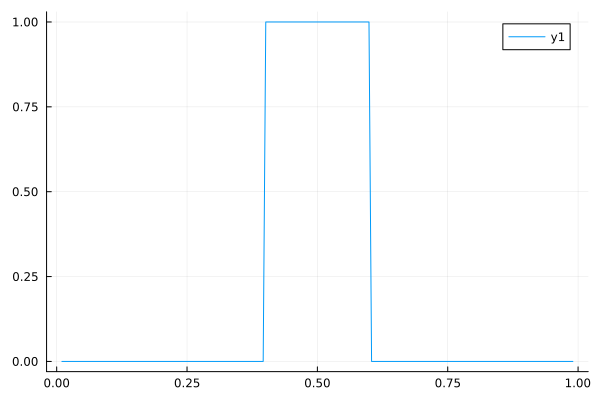

In [64]:
using Plots

# initial condition
b = zeros(n)
b[80:120] = ones(41)
plot(range(0.01, 0.99, length=n), b)

In the exact (weak) solution, the square-wave moves to the right with velocity $v=1$, i.e., $u(x,t)=u(0,x-vt)$ (at least, until it hits the boundary). What do you observe in the numerical solution?

Try out the second gaussian initial condition too!

┌ Info: Saved animation to c:\Users\phros\Github\18335\psets\tmp.gif
└ @ Plots C:\Users\phros\.julia\packages\Plots\M4dfL\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\phros\\Github\\18335\\psets\\tmp.gif")
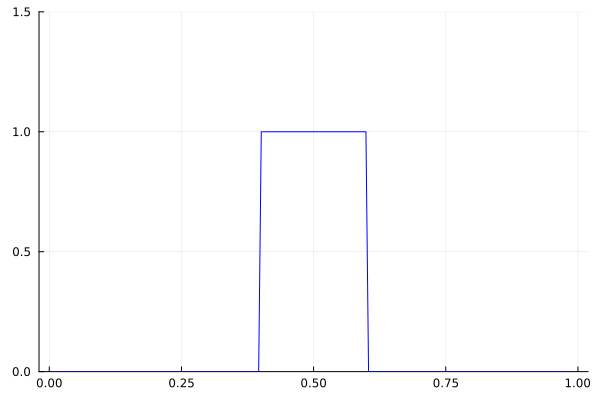

In [65]:
# initial condition 1 (square-wave)
b = zeros(n)
b[80:120] = ones(41)

# initial condition 2 (gaussian)
#b = zeros(n)
#x = range(0.01, 0.99, length=n)
#b = exp.(-200*(x.-0.25).^2)

# time stepping gif
anim = Animation()
m = 100                         # number of steps in time 
for k ∈ 1:m                     # animate solution
    plot(range(0.01, 0.99, length=n), b, linecolor = :blue, legend = false)
    ylims!(0.0,1.5)
    b = advec_step(L,D,U,b)
    frame(anim)
end
gif(anim)

    

For a deeper understanding of the movie, one needs to go beyond linear algebra and understand the approximation properties of finite-difference schemes for partial differential equations like the advection equation.

# Problem 3: Regularized least-squares solutions

Consider the following $100\times 50$ ill-conditioned least-squares problem $Ax=b$, where the last $20$ singular values of $A$ decay rapidly to about $10^{-6}$.

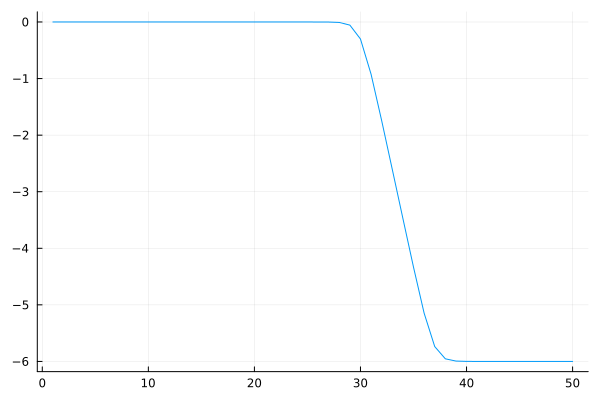

In [145]:
# singular values with decay profile
x = 1:50
v = 1e-6 .+ (1 ./ (1 .+ exp.(2*(x .- 30))))
plot(x,log10.(v), legend = false)

In [146]:
# matrix constructed from SVD
U = qr(rand(100,100)).Q
V = qr(randn(50,50)).Q
Σ = [diagm(v); zeros(50,50)]
A = U * Σ * V'
cond(A)

1.0000010000347686e6

Given a random right-hand side $b$, plot the terms $\|Ax_*-b\|$ and $\|x_*\|$ as $\lambda\rightarrow 0$.

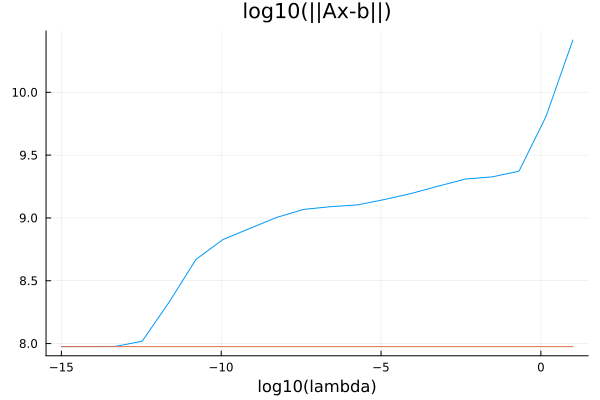

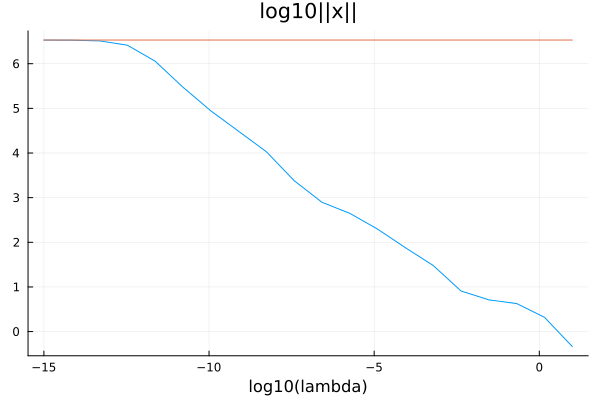

In [147]:
# random right-hand side
b = randn(100)

# "exact" least-squares solution (warning: ill-conditioned)
x0 = A \ b
res = norm(A*x0 - b)

# range of \lambda
l = 20
p = LinRange(-1,15,l)
λ = 10 .^ (-p)

# iterate over \lambda
errx = zeros(l)
resAx = zeros(l)
normx = zeros(l)
for j ∈ 1:l
    x = V * ( (Σ'*Σ+λ[j]*I) \ (Σ' * U' *b) )
    resAx[j] = norm(A*x-b)
    normx[j] = norm(x)
end

p1 = plot(log10.(λ), resAx, legend = false, title = "log10(||Ax-b||)", xlabel = "log10(lambda)")
plot!(log10.(λ), res * ones(length(λ)), legend = false)
p2 = plot(log10.(λ), log10.(normx), legend = false, title = "log10||x||", xlabel = "log10(lambda)")
plot!(log10.(λ), log10(norm(x0)) * ones(length(λ)), legend = false)
display(p1)
display(p2)


Now, try adjusting the singular value profile of $A$ (for example, lower the plateau at $10^{-6}$ to $10^{-9}$) and see what changes!